# Constrained transcripts
This script summarises transcript level constraints against nonsense variants in the UKB exomes.

We produce a list of genes where:
- The whole transcript is constrained for nonsense variants
- The transcript is constrained in our dataset, but does not meet the pLI / LOEUF thresholds
- The transcript is constrained specifically in NMD-escaping regions, stratified by:
  - 3' regions, long-exons
  - Unconstrained target regions, low pLI, high LOEUF
  
We produce the following outputs:
- Transcript level nonsense constraint (all transcripts)
- Transcript level nonsense constraint (constrained transcripts only)
- Regional nonsense constraint (all transcripts and regions)
- Regional nonsense constraint (constrained transcripts only)

## Preliminaries
Import modules, set plotting aesthetics, and download necessary data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set_context("talk")

In [2]:
%%bash

dx download -f data/supplementary_dataset_11_full_constraint_metrics.tsv -o ../data/
dx download -f data/230411_biomart_105_transcripts.tsv -o ../data

In [3]:
# Get gene symbols and IDs for each transcript
mart = pd.read_csv(
    "../data/230411_biomart_105_transcripts.tsv",
    sep="\t",
    header=0,
    names=["hgnc", "ensg", "enst"],
).set_index("enst")

# CCL3L1 and CCL3L3 (for example) are paralogs with identical ENSG and canonical ENST IDs.
# The second gene is dropped.
mart = mart.drop_duplicates("ensg")

## Nonsense constraint across whole transcripts
Assess constraint against nonsense variants in the full length of the transcript

### Read the data

In [4]:
# Read the constraint data to memory
df = pd.read_csv("../outputs/expected_variants_stats_no_cpg.tsv", sep="\t")

In [5]:
# Reformat the dataframe
df = df[
    [
        "enst",
        "csq",
        "n_pos",
        "prop_exp",
        "n_exp",
        "prop_obs",
        "n_obs",
        "oe",
        "oe_diff",
        "z",
        "p",
    ]
]
df = df.set_index(["enst", "csq"]).unstack("csq")
df.columns = df.columns.swaplevel(0, 1)
df.sort_index(axis=1, level=0, inplace=True, sort_remaining=False)
df.columns = df.columns.set_levels(["mis", "non", "syn"], level=0)
df.columns = ["_".join(x) for x in df.columns.to_flat_index()]

print(f"Number of transcripts: {len(df)}")

Number of transcripts: 19623


### Annotate with gene symbols and IDs

In [6]:
df = mart.merge(df, how="right", left_index=True, right_index=True)

### Exclude transcripts with fewer synonymous variants than expected
These likely represent poorly covered transcripts

**Note this is a hard filter applied at this stage**

In [7]:
m1 = df["syn_n_obs"] > 10
m2 = df["syn_z"] >= -1
m3 = df["mis_n_obs"] > 10

df = df[m1 & m2 & m3]
print(f"Number of transcripts: {len(df)}")

Number of transcripts: 14473


### Plot the distribution of nonsense Z-scores per transcript

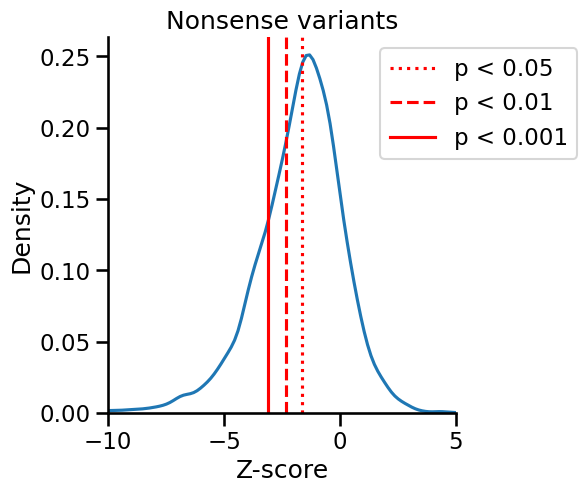

In [8]:
g = sns.displot(kind="kde", data=df, x=("non_z"))
g.set(
    xlim=(-10, 5),
    title="Nonsense variants",
    xlabel="Z-score",
)

# Add vertical lines for significance thresholds
p_values = 0.05, 0.01, 0.001
linestyles = ":", "--", "-"

for p, l in zip(p_values, linestyles):
    plt.axvline(
        x=norm.ppf(p),  # Critical value for one-tail Z-test
        color="r",
        linestyle=l,
        label=f"p < {p}",
    )

# Adjust the legend position
plt.legend(bbox_to_anchor=(0.75, 1), loc="upper left")

### Summarise the number of transcripts meeting p-value thresholds

In [9]:
def get_p_stats_transcript(df):
    p_vals = df[[("non_n_obs"), ("non_p")]].copy()
    p_vals["p_value_bin"] = pd.cut(p_vals["non_p"], bins=[0, 0.001, 0.01, 0.05, 1])
    p_stats = p_vals.groupby("p_value_bin").agg({"non_p": "count"})
    p_stats["zero_nonsense_observed"] = p_vals.groupby("p_value_bin")[
        "non_n_obs"
    ].apply(lambda x: (x == 0).sum())
    p_stats.columns = ["transcripts", "zero_nonsense_observed"]
    return p_stats


print(get_p_stats_transcript(df))

               transcripts  zero_nonsense_observed
p_value_bin                                       
(0.0, 0.001]          2998                     249
(0.001, 0.01]         1789                     126
(0.01, 0.05]          2165                     141
(0.05, 1.0]           7521                      50


### Save constrained transcripts to output

In [10]:
m1 = df["non_p"] < 0.001
m2 = df["non_p"] < 0.01
m3 = df["non_n_obs"] == 0

constrained = df[m1 | (m2 & m3)]
print(f"Number of constrained transcripts: {len(constrained)}")

(
    constrained.sort_values(["non_n_obs", "non_p"]).to_csv(
        "../outputs/constrained_transcripts.tsv", index=True, sep="\t"
    )
)

Number of constrained transcripts: 3124


## Compare Z-scores against LOEUF

### Get gnomAD pLI and LOEUF constraint data

In [11]:
pli = pd.read_csv(
    "../data/supplementary_dataset_11_full_constraint_metrics.tsv", sep="\t"
)
pli = pli.rename(columns={"transcript": "enst", "pLI": "pli", "oe_lof_upper": "loeuf"})
pli = pli.set_index("enst")

### Merge UKB and gnomAD constraint data

In [12]:
df = df.join(pli[["pli", "loeuf"]], how="left")

### Plot the relationship between the UKB nonsense Z-score and the gnomAD LOEUF score

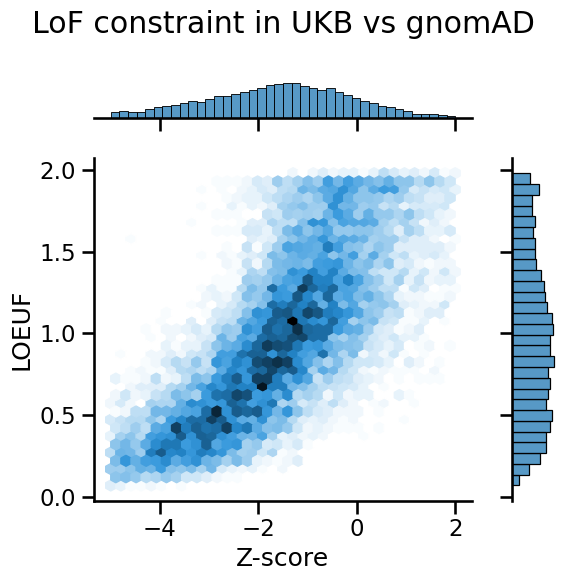

In [13]:
g = sns.jointplot(
    data=df[df["non_z"].between(-5, 2)],
    x=("non_z"),
    y="loeuf",
    kind="hex",
)
g.set_axis_labels(
    xlabel="Z-score",
    ylabel="LOEUF",
)
g.fig.suptitle("LoF constraint in UKB vs gnomAD")
g.fig.tight_layout()

## Find *new* transcripts constrained for nonsense variants
The greater sample size of UKB may allow us to detect nonsense constraint in more transcripts than in gnomAD. This is particularly true for small transcripts.

### Low pLI, high UKB constraint

In [14]:
get_p_stats_transcript(df[(df["pli"] < 0.9) | (df["pli"].isna())])

,transcripts,zero_nonsense_observed
p_value_bin,,
"(0.0, 0.001]",1513,59
"(0.001, 0.01]",1459,72
"(0.01, 0.05]",2042,127
"(0.05, 1.0]",7480,50


### High LOEUF, high UKB constraint

In [15]:
get_p_stats_transcript(df[(df["loeuf"] > 0.35) | (df["loeuf"].isna())])

,transcripts,zero_nonsense_observed
p_value_bin,,
"(0.0, 0.001]",1481,73
"(0.001, 0.01]",1506,83
"(0.01, 0.05]",2080,135
"(0.05, 1.0]",7495,50


### Newly constrained transcripts

In [16]:
# Transcripts below constraint thresholds in gnomAD
m4 = df["pli"] < 0.9
m5 = df["pli"].isna()
m6 = df["loeuf"] > 0.35
m7 = df["loeuf"].isna()

# Ignore large transcripts with very significant Z-scores,
# but only middling nonsense O/Es in UKB
m8 = df["non_oe"] <= 0.35

new = df[(m1 | (m2 & m3)) & ((m4 | m5) & (m6 | m7)) & m8].sort_values(["pli"])

print(f"Number of newly constrained transcripts: {len(new)}")

new.to_csv("../outputs/constrained_transcripts_new.tsv", index=True, sep="\t")

Number of newly constrained transcripts: 966


## Regional NMD constraint
Find constraint against nonsense variants in NMD-escaping and NMD-triggering regions

### Read NMD constraint data to memory

In [17]:
nmd = pd.read_csv("../outputs/expected_variants_stats_no_cpg_nmd.tsv", sep="\t")

### Annotate with gene symbols and IDs

In [18]:
nmd = nmd.set_index("enst")
nmd = mart.merge(nmd, how="right", left_index=True, right_index=True).reset_index()

### Reformat data

In [19]:
nmd = nmd.set_index(["hgnc", "ensg", "enst", "csq", "nmd"]).unstack(["csq", "nmd"])
nmd.columns = nmd.columns.swaplevel(0, 2).swaplevel(0, 1)
nmd.sort_index(axis=1, level=[0, 1], inplace=True, sort_remaining=False)
nmd.columns = nmd.columns.set_levels(["mis", "non", "syn"], level=0)
nmd.columns = nmd.columns.set_levels(
    ["distal", "long_exon", "nmd", "proximal"], level=1
)
nmd.columns = ["_".join(x) for x in nmd.columns.to_flat_index()]
nmd = nmd.reset_index(level=["hgnc", "ensg"])

### Merge with pLI and LOEUF annotations

In [20]:
nmd = nmd.join(pli[["pli", "loeuf"]], how="left")

### Plot regional nonsense constraint Z-scores

In [21]:
def plot_regional_z_score(df, x, title):
    g = sns.displot(kind="kde", data=df, x=x)
    g.set(title=title, xlabel="Z-score", xlim=(-5, 5))

    plt.axvline(x=-1.645, color="r", linestyle=":", label="p < 0.05")
    plt.axvline(x=-2.326, color="r", linestyle="--", label="p < 0.01")
    plt.axvline(x=-3.09, color="r", linestyle="-", label="p < 0.001")

    plt.legend(bbox_to_anchor=(0.5, 0.9), loc="upper left")

    return g

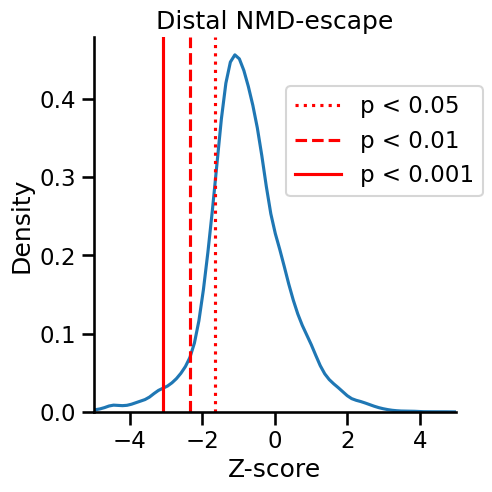

In [22]:
g = plot_regional_z_score(df=nmd, x="non_distal_z", title="Distal NMD-escape")

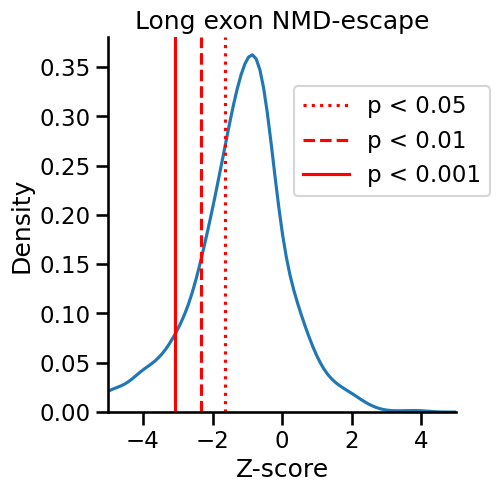

In [23]:
g = plot_regional_z_score(df=nmd, x="non_long_exon_z", title="Long exon NMD-escape")

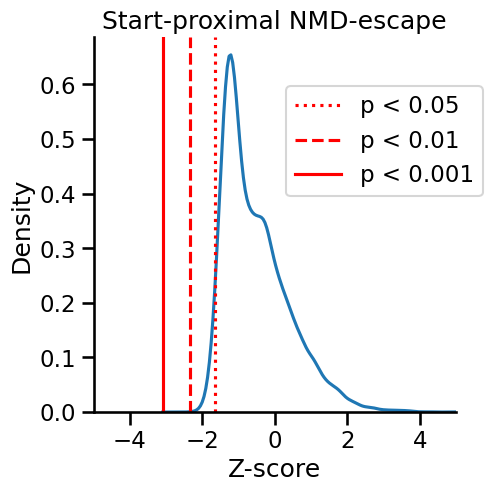

In [24]:
g = plot_regional_z_score(df=nmd, x="non_proximal_z", title="Start-proximal NMD-escape")

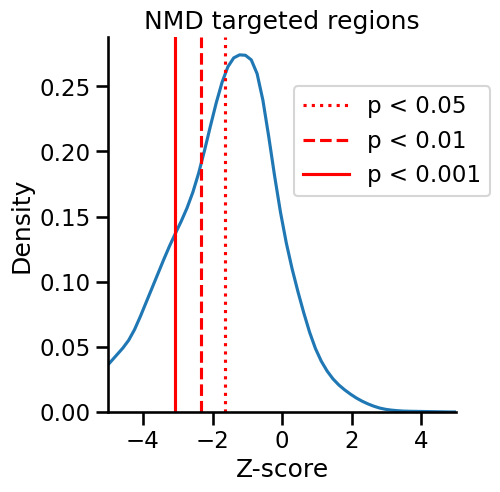

In [25]:
g = plot_regional_z_score(df=nmd, x="non_nmd_z", title="NMD targeted regions")

### Count transcripts at p-value thresholds

In [26]:
def get_p_stats_region(df, region):
    p_vals = df[["non_" + region + "_n_obs", "non_" + region + "_p"]].copy()
    p_vals.columns = ["n_obs", "p"]
    p_vals["p_bin"] = pd.cut(p_vals["p"], bins=[0, 0.001, 0.01, 0.05, 1])
    p_stats = p_vals.groupby("p_bin").agg({"p": "count"})
    p_stats["none_observed"] = p_vals.groupby("p_bin")["n_obs"].apply(
        lambda x: (x == 0).sum()
    )
    return p_stats

In [27]:
regions = ["distal", "long_exon", "nmd", "proximal"]

for r in regions:
    df = nmd[nmd[("syn_" + r + "_z")] > -1].copy()
    print(f"\n{r}")
    print(get_p_stats_region(df, region=r))


distal
                   p  none_observed
p_bin                              
(0.0, 0.001]     290             59
(0.001, 0.01]    414             82
(0.01, 0.05]    1439            750
(0.05, 1.0]    12837           3489

long_exon
                  p  none_observed
p_bin                             
(0.0, 0.001]    266             56
(0.001, 0.01]   221             71
(0.01, 0.05]    397            156
(0.05, 1.0]    1949            644

nmd
                  p  none_observed
p_bin                             
(0.0, 0.001]   1976            275
(0.001, 0.01]  1309            196
(0.01, 0.05]   1813            314
(0.05, 1.0]    6926            962

proximal
                   p  none_observed
p_bin                              
(0.0, 0.001]       0              0
(0.001, 0.01]      1              1
(0.01, 0.05]     380            376
(0.05, 1.0]    15681           6158


## NMD region-specific constraint
Identify transcripts in which nonsense variants are specifically constrained in NMD-escape regions

In [28]:
_nmd = nmd.copy()

### Annotate constrained regions

In [29]:
regions = ["distal", "long_exon", "nmd"]

for region in regions:
    m1 = nmd["non_" + region + "_p"] < 0.001
    m2 = nmd["non_" + region + "_p"] < 0.01
    m3 = nmd["non_" + region + "_n_obs"] == 0
    m4 = nmd["syn_" + region + "_z"] > -1

    nmd[region] = np.where(m4 & (m1 | (m2 & m3)), region + ",", "")

# Combine the region annotations into one column
nmd["constrained_region"] = [
    "".join([w, x, y]) for w, x, y in zip(nmd["distal"], nmd["long_exon"], nmd["nmd"])
]
nmd["constrained_region"] = nmd["constrained_region"].str.strip(",")

# Drop superfluous columns
a = ["hgnc", "ensg"]
suffix = ["_n_exp", "_n_obs", "_z", "_p"]
b = ["non_" + r + s for r in regions for s in suffix]
c = ["pli", "loeuf", "constrained_region"]
columns = a + b + c

nmd = nmd[columns]

### Specific constraint in NMD-targeted regions
Find transcripts which are specifically constrained for nonsense variants which trigger NMD.

In [30]:
def write_out(df, region):
    print(f"Transcripts constrained for {region} nonsense variants: {len(df)}")
    print(f"... in which pLI / LOEUF annotations are missing: {len(df[df.pli.isna()])}")

    df = df.sort_values([f"non_{region}_n_obs", f"non_{region}_p"])
    df.to_csv(f"../outputs/constrained_transcripts_{region}.tsv", index=True, sep="\t")

    return df

In [31]:
def constraint_filter(df, region):
    # Individual filters
    m1 = df["pli"] < 0.9
    m2 = df["pli"].isna()
    m3 = df["loeuf"] > 0.35
    m4 = df["loeuf"].isna()
    ## Ignore large transcripts with very significant Z-scores,
    ## but only a moderate nonsense O/E ratio in UKB
    m5 = (df[f"non_{region}_n_obs"] / df[f"non_{region}_n_exp"]) <= 0.35

    # Apply filters
    df = df[(m1 | m2) & (m3 | m4) & m5]

    return df

In [32]:
# Select transcripts constrained in NMD regions
region = "nmd"
df = nmd[nmd["constrained_region"] == region]

# Filter transcripts
df = constraint_filter(df=df, region=region)

# Write to output
df = write_out(df, region)

Transcripts constrained for nmd nonsense variants: 605
... in which pLI / LOEUF annotations are missing: 137


### Specific constraint in long exons
Find transcripts which are specifically constrained for nonsense variants in long exons predicted to escape NMD.

In [33]:
# Select transcripts constrained in NMD regions
region = "long_exon"
df = nmd[
    nmd["constrained_region"].str.contains(region)
    & (~nmd["constrained_region"].str.contains("nmd"))
]

# Filter transcripts
df = constraint_filter(df=df, region=region)

# Write to output
df = write_out(df, region)

Transcripts constrained for long_exon nonsense variants: 63
... in which pLI / LOEUF annotations are missing: 18


### Specific constraint in distal regions
Find transcripts which are specifically constrained for nonsense variants in their 3' ends.

In [34]:
# Select transcripts constrained in NMD regions
region = "distal"
df = nmd[
    nmd["constrained_region"].str.contains(region)
    & (~nmd["constrained_region"].str.contains("nmd"))
]

# Filter transcripts
df = constraint_filter(df=df, region=region)

# Write to output
df = write_out(df, region)

Transcripts constrained for distal nonsense variants: 147
... in which pLI / LOEUF annotations are missing: 34
